In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# This related to plotting datetime values with matplotlib
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
df = pd.read_csv("./Data/TimeSeriesData/Alcohol_Sales.csv", index_col=0, parse_dates=True)

In [3]:
df.columns

Index(['S4248SM144NCEN'], dtype='object')

In [4]:
len(df)

325

In [5]:
df = df.dropna()

In [6]:
len(df)

325

<Axes: xlabel='DATE'>

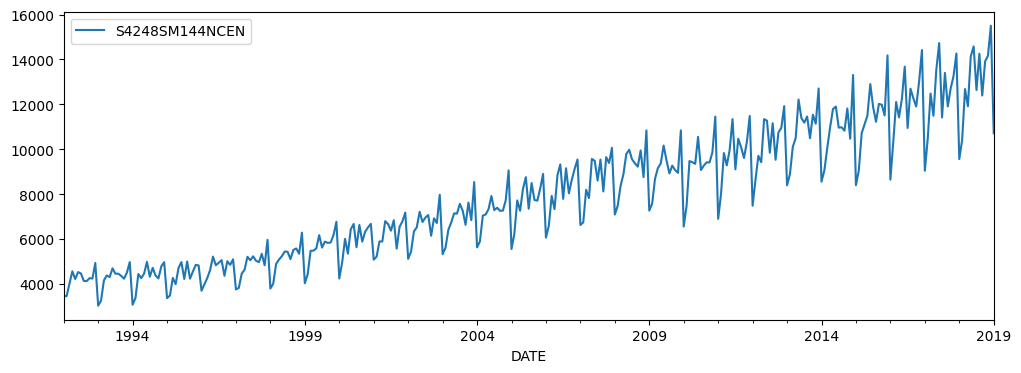

In [7]:
df.plot(figsize=(12,4))

In [8]:
y = df["S4248SM144NCEN"].values.astype(float)

In [9]:
test_size = 12

In [10]:
train_set = y[:-test_size]
test_set = y[-test_size:]

In [11]:
test_set

array([10415., 12683., 11919., 14138., 14583., 12640., 14257., 12396.,
       13914., 14174., 15504., 10718.])

In [12]:
from sklearn.preprocessing import MinMaxScaler

In [13]:
scaler = MinMaxScaler(feature_range=(-1,1))

In [14]:
scaler.fit(train_set.reshape(-1,1))

MinMaxScaler(feature_range=(-1, 1))

In [15]:
train_norm = scaler.transform(train_set.reshape(-1,1))

In [16]:
# len(y) - test_size - window_size

In [17]:
train_norm = torch.FloatTensor(train_norm).view(-1)

In [18]:
window_size = 12

In [19]:
def input_data(seq, ws):
    out = []
    L = len(seq)

    for i in range(L - ws):
        window = seq[i: i+ws]
        label = seq[i+ws: i+ws+1]
        out.append((window, label))

    return out

In [20]:
train_data = input_data(train_norm, window_size)

In [21]:
len(train_data)

301

In [22]:
train_data[0]

(tensor([-0.9268, -0.9270, -0.8340, -0.7379, -0.7966, -0.7439, -0.7547, -0.8109,
         -0.8128, -0.7901, -0.7933, -0.6743]),
 tensor([-1.]))

In [23]:
class LSTMnetwork(nn.Module):
    def __init__(self,input_size=1,hidden_size=100,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Add an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size)
        
        # Add a fully-connected layer:
        self.linear = nn.Linear(hidden_size,output_size)
        
        # Initialize h0 and c0:
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]  # we only want the last value

In [24]:
torch.manual_seed(101)
model = LSTMnetwork()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [25]:
model

LSTMnetwork(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [26]:
epochs = 150

import time
start_time = time.time()

for epoch in range(epochs):

    for seq, y_train in train_data:
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                       torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)

        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch} Loss: {loss.item()}")


total_time = time.time() - start_time
print(total_time/60)

Epoch 0 Loss: 0.25310203433036804
Epoch 1 Loss: 0.3753196895122528
Epoch 2 Loss: 0.3902722895145416
Epoch 3 Loss: 0.34934669733047485
Epoch 4 Loss: 0.3308565616607666
Epoch 5 Loss: 0.3322998285293579
Epoch 6 Loss: 0.3267035484313965
Epoch 7 Loss: 0.32074135541915894
Epoch 8 Loss: 0.3065352737903595
Epoch 9 Loss: 0.29518038034439087
Epoch 10 Loss: 0.2693432867527008
Epoch 11 Loss: 0.25998395681381226
Epoch 12 Loss: 0.2466599941253662
Epoch 13 Loss: 0.22403942048549652
Epoch 14 Loss: 0.18602675199508667
Epoch 15 Loss: 0.1856120526790619
Epoch 16 Loss: 0.17209352552890778
Epoch 17 Loss: 0.2516058087348938
Epoch 18 Loss: 0.2255730777978897
Epoch 19 Loss: 0.17445692420005798
Epoch 20 Loss: 0.20232586562633514
Epoch 21 Loss: 0.20828290283679962
Epoch 22 Loss: 0.16656506061553955
Epoch 23 Loss: 0.1757877916097641
Epoch 24 Loss: 0.11992356926202774
Epoch 25 Loss: 0.09208659827709198
Epoch 26 Loss: 0.04090915247797966
Epoch 27 Loss: 0.035774242132902145
Epoch 28 Loss: 0.005770871881395578
Epoch

In [27]:
future = 12

preds = train_norm[-window_size:].tolist()

model.eval()

for i in range(future):

    seq = torch.FloatTensor(preds[-window_size:])

    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                       torch.zeros(1,1,model.hidden_size))

        preds.append(model(seq).item())

In [28]:
preds[window_size:]

[0.18784859776496887,
 0.5317348837852478,
 0.46062445640563965,
 0.7770543694496155,
 0.8928593993186951,
 0.512744128704071,
 0.7751469016075134,
 0.5024493932723999,
 0.6578863263130188,
 0.676203191280365,
 0.8935836553573608,
 0.07773305475711823]

In [29]:
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1,1))

In [30]:
len(true_predictions)

12

In [31]:
df["S4248SM144NCEN"][-12:]

DATE
2018-02-01    10415
2018-03-01    12683
2018-04-01    11919
2018-05-01    14138
2018-06-01    14583
2018-07-01    12640
2018-08-01    14257
2018-09-01    12396
2018-10-01    13914
2018-11-01    14174
2018-12-01    15504
2019-01-01    10718
Name: S4248SM144NCEN, dtype: int64

In [32]:
x = np.arange("2018-02-01", "2019-02-01", dtype="datetime64[M]")

In [33]:
x

array(['2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07',
       '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01'],
      dtype='datetime64[M]')

In [34]:
df.index

DatetimeIndex(['1992-01-01', '1992-02-01', '1992-03-01', '1992-04-01',
               '1992-05-01', '1992-06-01', '1992-07-01', '1992-08-01',
               '1992-09-01', '1992-10-01',
               ...
               '2018-04-01', '2018-05-01', '2018-06-01', '2018-07-01',
               '2018-08-01', '2018-09-01', '2018-10-01', '2018-11-01',
               '2018-12-01', '2019-01-01'],
              dtype='datetime64[ns]', name='DATE', length=325, freq=None)

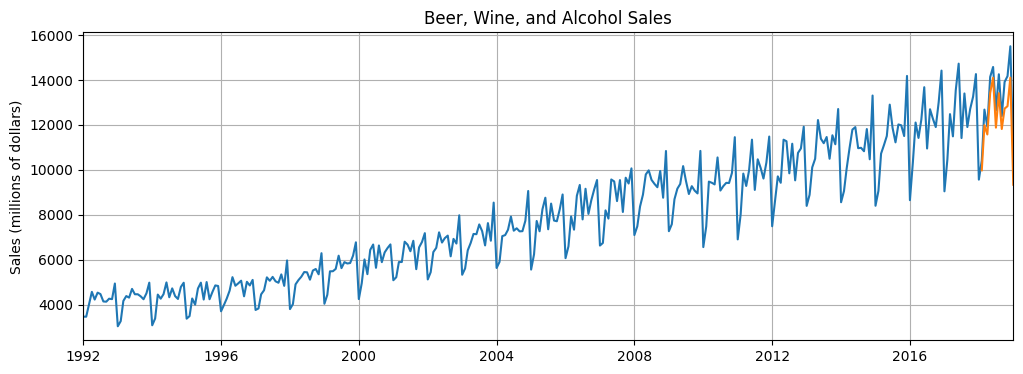

In [35]:
plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x,true_predictions)
plt.show()

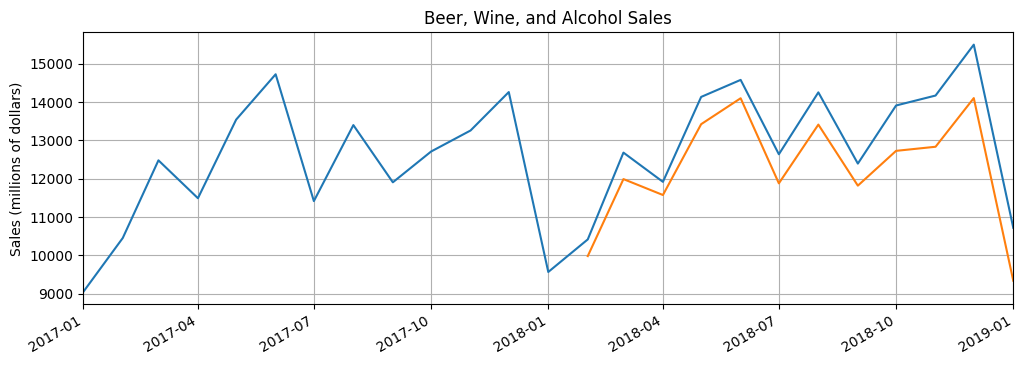

In [36]:
# Plot the end of the graph
fig = plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()

# Select the end of the graph with slice notation:
plt.plot(df['S4248SM144NCEN']['2017-01-01':])
plt.plot(x,true_predictions)
plt.show()

In [37]:
epochs = 150

# set model to back to training mode
model.train()

# feature scale the entire dataset
y_norm = scaler.fit_transform(y.reshape(-1, 1))
y_norm = torch.FloatTensor(y_norm).view(-1)
all_data = input_data(y_norm,window_size)

import time
start_time = time.time()

for epoch in range(epochs):
    
    # train on the full set of sequences
    for seq, y_train in all_data:  
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    # print training result
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.02401253
Epoch:  2 Loss: 0.01385437
Epoch:  3 Loss: 0.02226301
Epoch:  4 Loss: 0.01801860
Epoch:  5 Loss: 0.02040029
Epoch:  6 Loss: 0.01175199
Epoch:  7 Loss: 0.01274839
Epoch:  8 Loss: 0.00853451
Epoch:  9 Loss: 0.01103902
Epoch: 10 Loss: 0.00980429
Epoch: 11 Loss: 0.00516277
Epoch: 12 Loss: 0.00539621
Epoch: 13 Loss: 0.00593913
Epoch: 14 Loss: 0.00914917
Epoch: 15 Loss: 0.00320046
Epoch: 16 Loss: 0.00582353
Epoch: 17 Loss: 0.00090200
Epoch: 18 Loss: 0.00591624
Epoch: 19 Loss: 0.00342259
Epoch: 20 Loss: 0.00057859
Epoch: 21 Loss: 0.00138111
Epoch: 22 Loss: 0.00288639
Epoch: 23 Loss: 0.00125508
Epoch: 24 Loss: 0.00648076
Epoch: 25 Loss: 0.00499044
Epoch: 26 Loss: 0.00151692
Epoch: 27 Loss: 0.00237859
Epoch: 28 Loss: 0.00351499
Epoch: 29 Loss: 0.00367814
Epoch: 30 Loss: 0.00397234
Epoch: 31 Loss: 0.00449822
Epoch: 32 Loss: 0.00652361
Epoch: 33 Loss: 0.00501120
Epoch: 34 Loss: 0.00439738
Epoch: 35 Loss: 0.01073497
Epoch: 36 Loss: 0.00659603
Epoch: 37 Loss: 0.00405320
E

In [38]:
window_size = 12
future = 12
L = len(y)

preds = y_norm[-window_size:].tolist()

model.eval()
for i in range(future):

    seq = torch.FloatTensor(preds[-window_size:])

    with torch.no_grad():
         
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        preds.append(model(seq).item())

        

In [39]:
true_predictions = scaler.inverse_transform(np.array(preds).reshape(-1,1))

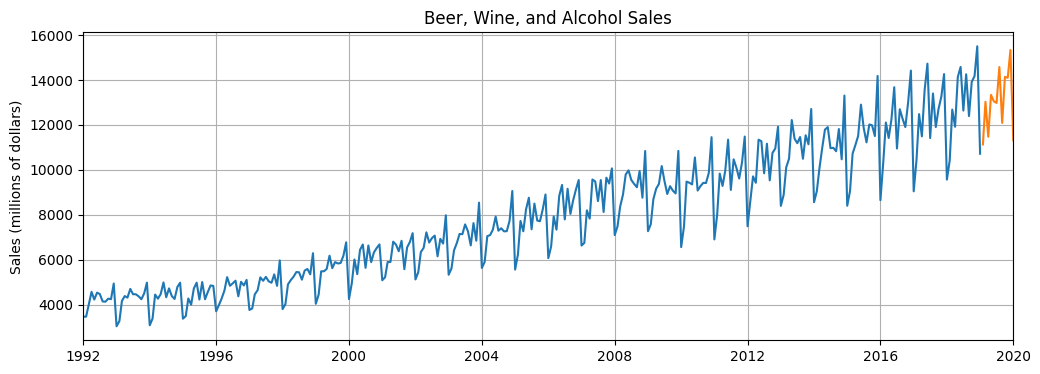

In [40]:
# Remember that the stop date has to be later than the last predicted value.
x = np.arange('2019-02-01', '2020-02-01', dtype='datetime64[M]').astype('datetime64[D]')

plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x,true_predictions[window_size:])
plt.show()

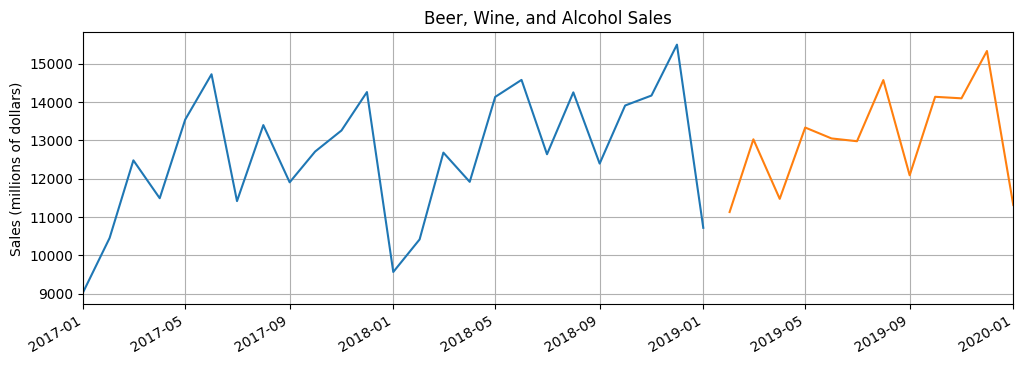

In [41]:
fig = plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()
plt.plot(df['S4248SM144NCEN']['2017-01-01':])
plt.plot(x,true_predictions[window_size:])
plt.show()